# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

---

In this notebook, we train a CNN on augmented images from the CIFAR-10 database.

### 1. Load CIFAR-10 Database

In [1]:
import keras
from keras.datasets import cifar10

# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


In [2]:
x_train.shape

(50000, 32, 32, 3)

可以看出数据已经是TensorFlow格式的了，3个channel似乎是rgb的顺序，不过不用transfer的话并不要紧（vgg什么的可能是按gbr顺序训练的，以后会见到）
label还不是one hot的，需要处理
数据还是0-255的，也需要scale一下

In [3]:
# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### 2. Visualize the First 24 Training Images

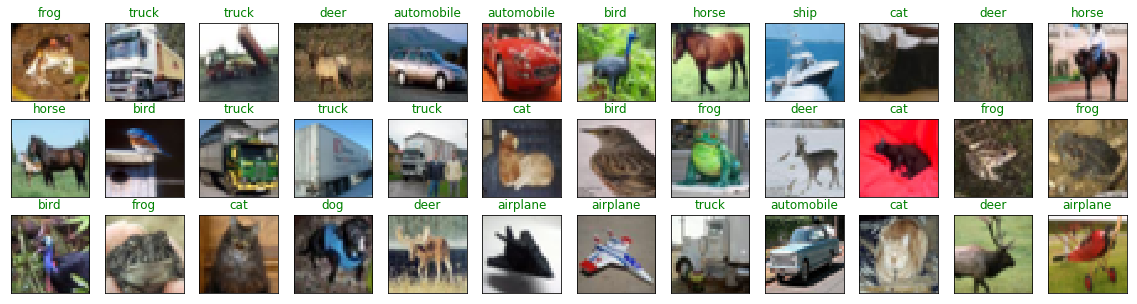

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(cifar10_labels[y_train[i][0]]), color="green")

### 3. Rescale the Images by Dividing Every Pixel in Every Image by 255

In [5]:
# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255 

### 4.  Break Dataset into Training, Testing, and Validation Sets

In [6]:
from keras.utils import np_utils

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


### 5. Create and Configure Augmented Image Generator

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data 看起来在这没什么用啊
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)

### 6. Visualize Original and Augmented Images

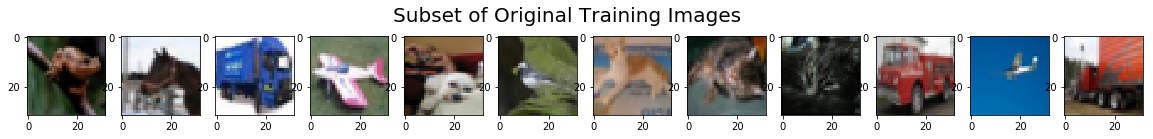

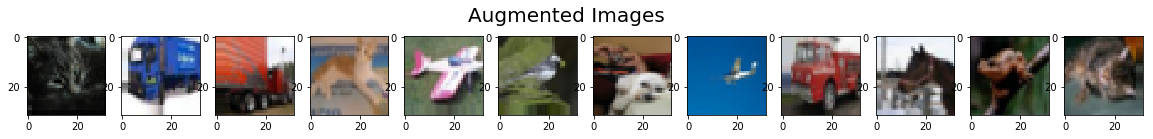

In [9]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### 7. Define the Model Architecture 

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        416       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        8256      
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 128)         32896     
__________

### 8. Compile the Model 

In [27]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])

### 9. Train the Model 

In [28]:
from keras.callbacks import ModelCheckpoint   

batch_size = 32
epochs = 6

train_batch = datagen_train.flow(x_train, y_train, batch_size=batch_size)
test_batch = datagen_valid.flow(x_valid, y_valid, batch_size=batch_size)
# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(train_batch,
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=1,
                    validation_data=test_batch,
                    validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/6
1406/1406 [==============================] - 28s - loss: 1.5665 - acc: 0.4444 - val_loss: 1.3550 - val_acc: 0.5018
Epoch 2/6
1406/1406 [==============================] - 27s - loss: 1.2220 - acc: 0.5642 - val_loss: 1.0771 - val_acc: 0.6159
Epoch 3/6
1406/1406 [==============================] - 27s - loss: 1.1039 - acc: 0.6094 - val_loss: 1.2305 - val_acc: 0.5606
Epoch 4/6
1406/1406 [==============================] - 27s - loss: 1.0438 - acc: 0.6327 - val_loss: 1.1171 - val_acc: 0.6041
Epoch 5/6
1406/1406 [==============================] - 27s - loss: 0.9886 - acc: 0.6512 - val_loss: 0.9011 - val_acc: 0.6836
Epoch 6/6
1406/1406 [==============================] - 27s - loss: 0.9482 - acc: 0.6688 - val_loss: 0.9065 - val_acc: 0.6830


In [33]:
model.optimizer.lr = 0.1
epochs = 4
model.fit_generator(train_batch,
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=1,
                    validation_data=test_batch,
                    validation_steps=x_valid.shape[0] // batch_size)

model.optimizer.lr = 0.01
epochs = 6
model.fit_generator(train_batch,
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=1,
                    validation_data=test_batch,
                    validation_steps=x_valid.shape[0] // batch_size)

model.optimizer.lr = 0.001
epochs = 8
model.fit_generator(train_batch,
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=1,
                    validation_data=test_batch,
                    validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/4
1406/1406 [==============================] - 27s - loss: 0.6888 - acc: 0.7610 - val_loss: 0.6624 - val_acc: 0.7667
Epoch 2/4
1406/1406 [==============================] - 27s - loss: 0.6824 - acc: 0.7651 - val_loss: 6.1450 - val_acc: 0.2224
Epoch 3/4
1406/1406 [==============================] - 27s - loss: 0.6872 - acc: 0.7617 - val_loss: 0.6253 - val_acc: 0.7874
Epoch 4/4
1406/1406 [==============================] - 27s - loss: 0.6746 - acc: 0.7677 - val_loss: 0.5940 - val_acc: 0.8017
Epoch 1/6
1406/1406 [==============================] - 27s - loss: 0.6612 - acc: 0.7720 - val_loss: 0.5753 - val_acc: 0.7985
Epoch 2/6
1406/1406 [==============================] - 27s - loss: 0.6580 - acc: 0.7723 - val_loss: 0.8062 - val_acc: 0.7126
Epoch 3/6
1406/1406 [==============================] - 27s - loss: 0.6495 - acc: 0.7758 - val_loss: 1.1609 - val_acc: 0.5996
Epoch 4/6
1406/1406 [==============================] - 27s - loss: 0.6552 - acc: 0.7737 - val_loss: 0.6014 - val_acc: 0.7945


### 10. Load the Model with the Best Validation Accuracy

In [36]:
# load the weights that yielded the best validation accuracy
model.save_weights('aug_model.weights.hdf5')
model.load_weights('aug_model.weights.hdf5')

### 11. Calculate Classification Accuracy on Test Set

In [37]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7222


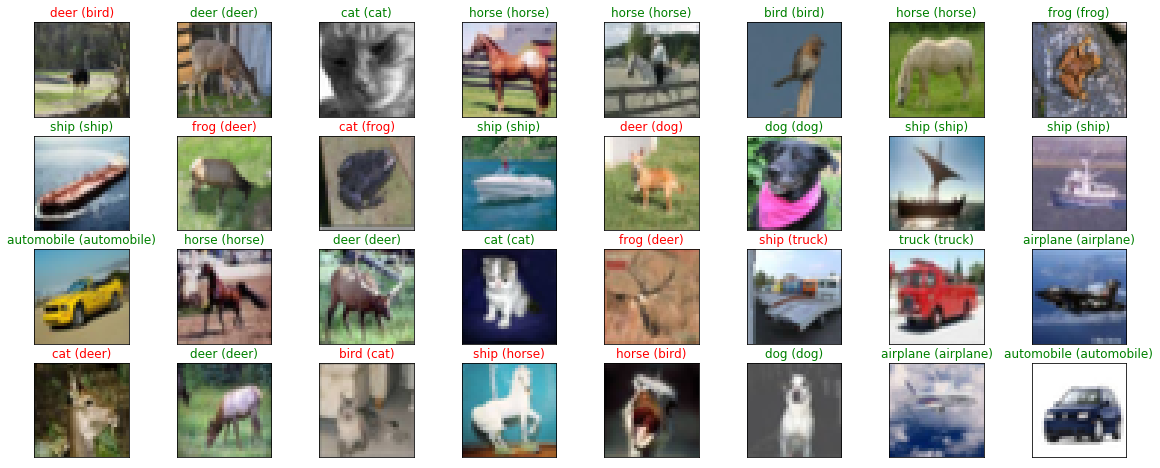

In [39]:
# get predictions on the test set
y_hat = model.predict(x_test)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))